In [1]:
#IMPORTING THE NECESSARY LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_data = pd.read_csv('Ticket_data_preprocessed.csv')

In [3]:
raw_data.head(2)

,Airline,Destination,Total_Stops,Price,Month of Journey,Day of Journey,Dep_Time_hour,Dep_Time_minutes,Arrival_Time_hour,Arrival_Time_minutes,duration_hours,duration_minutes,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897.0,3,24,22,20,1,10,2,50,1,0,0,0,0
1,7,3,2,7662.0,1,5,5,50,13,15,7,25,0,1,0,0,0


<h4> Feature Selection </h4>

In [4]:
from sklearn.feature_selection import mutual_info_regression

In [5]:
X = raw_data.drop(['Price'], axis = 1)

In [6]:
y = raw_data['Price']

In [7]:
features = pd.DataFrame(mutual_info_regression(X, y), index = X.columns)
features.columns=['Importance']

In [8]:
features.sort_values(by='Importance', ascending=False)

,Importance
Destination,0.996886
Airline,0.982110
Total_Stops,0.792679
Source_Delhi,0.521859
duration_hours,0.459150
Source_Kolkata,0.455726
Arrival_Time_hour,0.400481
Source_Banglore,0.386583
Arrival_Time_minutes,0.348766
duration_minutes,0.341958


<h4> Building the model </h4>

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 22)

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
ml_model = RandomForestRegressor()

In [13]:
#Fitting the model
model = ml_model.fit(X_train, y_train)

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_pred

array([ 5451.511     , 10344.45      , 11887.23916667, ...,
       12297.8975    , 10235.25      , 10019.9805    ])

In [16]:
y_pred.shape

(2671,)

In [17]:
len(X_test)

2671

<h4> Saving the model </h4>

In [18]:
import pickle

In [19]:
file = open('rf_model.pkl', 'wb')

In [20]:
pickle.dump(model, file)

In [21]:
#Using the Saved model

model = open('rf_model.pkl', 'rb')

In [22]:
forest = pickle.load(model)

In [23]:
forest.predict(X_test)

array([ 5451.511     , 10344.45      , 11887.23916667, ...,
       12297.8975    , 10235.25      , 10019.9805    ])

<h4> Defining the Model's Evaluation Metrics </h4>

Automating machine learning pipeline

In [24]:
def predict(ml_model):
    model = ml_model.fit(X_train, y_train)
    print('Training Score: {}'.format(model.score(X_train, y_train)))
    print('The predictions are: {}'.format(y_pred))
    print('\n')
    
    from sklearn import metrics
    print('r2_score: {}'.format(metrics.r2_score(y_test, y_pred)))
    print('MSE: {}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('MAE: {}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print('MAPE: {}'.format(metrics.mean_absolute_percentage_error(y_test, y_pred)))
    sns.displot(y_test-y_pred)

Training Score: 0.952227977275415
The predictions are: [ 5451.511      10344.45       11887.23916667 ... 12297.8975
 10235.25       10019.9805    ]


r2_score: 0.8166783696537518
MSE: 3364471.0061384547
MAE: 1180.9087681610165
RMSE: 1834.2494394543112
MAPE: 0.1330909879277825


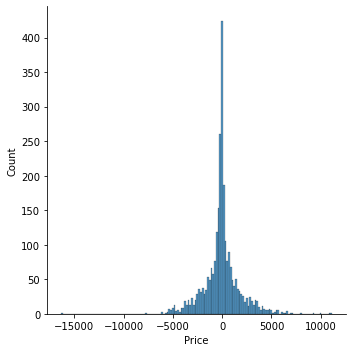

In [25]:
predict(ml_model)

From the analysis above, at most instances, the model is performing optimally.

<h4> Hyperparameter Tuning using RandomSearch CV </h4>

In [26]:
from sklearn.model_selection import RandomizedSearchCV

In [27]:
n_estimators = [int(x) for x in np.linspace(start=1000, stop=1200, num=6)]

max_features = ["auto", 'sqrt']

max_depth = [int(x) for x in np.linspace(start=5, stop=30, num=4)]

min_samples_split = [5, 10, 15, 100]

In [28]:
random_grid = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split
}

In [29]:
rf_Random = RandomizedSearchCV(ml_model, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)

In [30]:
tuned_model=rf_Random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [31]:
tuned_model

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [1000, 1040, 1080, 1120,
                                                         1160, 1200]},
                   verbose=2)

In [32]:
tuned_model.best_params_

{'n_estimators': 1080,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 13}

In [33]:
pred2=rf_Random.predict(X_test)
pred2

array([ 4985.87274386, 10355.80882233, 13076.79352713, ...,
       12481.13908773, 10516.83210197, 10935.35752279])

In [34]:
from sklearn import metrics
metrics.r2_score(y_test,pred2)

0.8466541465854103

<h4> Saving the tuned model </h4>

In [35]:
import pickle

In [36]:
file = open('tuned_model.pkl', 'wb')

In [37]:
pickle.dump(tuned_model, file)

In [38]:
#Using the Saved model

model = open('tuned_model.pkl', 'rb')

In [39]:
tuned = pickle.load(model)

In [40]:
tuned.predict(X_test)

array([ 4985.87274386, 10355.80882233, 13076.79352713, ...,
       12481.13908773, 10516.83210197, 10935.35752279])